# Intialize

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time


# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf)
# TT,TE,EE+lowE+lensing+BAO
cosmo_params_comparison = {
'omega_b': 0.0224178568132,
'omega_cdm':  0.11933148326520002,
'H0': 67.66,
'tau_reio': 0.0561,
'ln10^{10}A_s': 2.9799585,
'n_s': 0.96,

    
# 'k_pivot': 0.05,
# 'N_ncdm': 1,
# 'N_ur': 2.0328,
# 'm_ncdm': 0.06  
    
}
h = cosmo_params_comparison['H0']/100.
# Om0 = 0.30964
# Ob0 = 0.04897
# h = 0.6766
# sigma_8 = 0.795
# n_s = 0.96
# A_s = 1.9687e-9#2.174986e-09#*0.76/0.823

# Ob0*h**2
# Om0*h**2-Ob0*h**2
# np.log(1e10*A_s)



common_params = {


'mass function' : 'M500',

}

Metal device set to: Apple M1 Pro


2023-03-24 20:10:29.121800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 20:10:29.121911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import classy_szfast

# Unbinned computation

In [4]:

szcounts_param ={
 

'output': 'sz_cluster_counts_fft',
'use_skyaveraged_noise': 1,
    
'signal-to-noise_cut-off_for_survey_cluster_completeness':6.,
'experiment' : 0, # planck
'y_m_relation' : 0, # planck
'm_pivot_ym_[Msun]': 3e14,    

'M_min' : 1e13*h, 
'M_max' : 1e16*h,
    
# 'ndim_masses' : 2000, # now muted/set by k's in cosmopower emulator.
'ndim_redshifts' :1850,
# tabulation of mass function:
'n_z_dndlnM' : 1850,
'szcounts_fft_nz' : 1850,
'n_m_dndlnM' : 1000,
    
'sigmaM_ym' : 0.173,

'N_samp_fftw' : 2**12,



'z_min' : 0.0,
'z_max' : 1.02,
    
'szcounts_fft_z_min' : 0.01,
'szcounts_fft_z_max' : 1.01,
    
'B':1.25,
    
    
'tol_dlnm_dlnq':0.2,
'ntab_dlnm_dlnq':1000,

'szcounts_qmax_fft_padded':200.,
    
    
'sigma_derivative': 0, # 0 is gradient, and 1 is mcfit
'HMF_prescription_NCDM': 1,
    
'no_spline_in_tinker': 1
}

In [6]:
%%time

M = Class()
M.set(common_params)
M.set(cosmo_params_comparison)
M.set(szcounts_param)
# M.set({'output':''})
M.compute_class_szfast()
# M.compute()

CPU times: user 28.3 s, sys: 3.19 s, total: 31.4 s
Wall time: 26.1 s


In [7]:
%%time
szcounts = M.szcounts_ntot_rates_loglike()
print(szcounts['ntot'],szcounts['loglike'])

625.7197619488919 1478.9427435544285
CPU times: user 180 ms, sys: 10.8 ms, total: 191 ms
Wall time: 182 ms


In [9]:
zmin = szcounts_param['szcounts_fft_z_min']
zmax = szcounts_param['szcounts_fft_z_max']
nz = szcounts_param['szcounts_fft_nz']
z_arr = np.linspace(zmin,zmax,nz)

q_threshold = 6.
q_max = 100.
nq = 5000
# q_arr = np.linspace(q_threshold, q_max,nq)
q_arr = np.geomspace(q_threshold, q_max,nq)

In [10]:
dq = (q_max-q_threshold)/(nq-1.)
dz = (zmax - zmin)/(nz-1.)

In [11]:
get_dndzdq = np.vectorize(M.get_szcounts_dndzdq_at_z_q)

In [13]:

import scipy.integrate as integrate
Nz = []
for zp in z_arr:
    # Nz.append(np.trapz(get_dndzdq(zp,q_arr)*q_arr,x=np.log(q_arr)))
    # Nz.append(integrate.simps(get_dndzdq(zp,q_arr)*q_arr,np.log(q_arr),axis=0))
    Nz.append(integrate.simps(get_dndzdq(zp,q_arr),q_arr,axis=0))
    # Nz.append(np.trapz(get_dndzdq(zp,q_arr),x=q_arr))
    # Nz.append(np.sum(get_dndzdq(zp,q_arr)*dq))
Nz = np.asarray(Nz)

In [14]:
Nq = []
for qp in q_arr:
    # Nq.append(np.trapz(get_dndzdq(z_arr,qp),x=z_arr))
    Nq.append(integrate.simps(get_dndzdq(z_arr,qp),z_arr,axis=0))
Nq = np.asarray(Nq)

In [15]:
Ntot = np.trapz(Nz,x=z_arr)
# Ntot = np.sum(Nz)*dz
Ntot

625.5406282574261

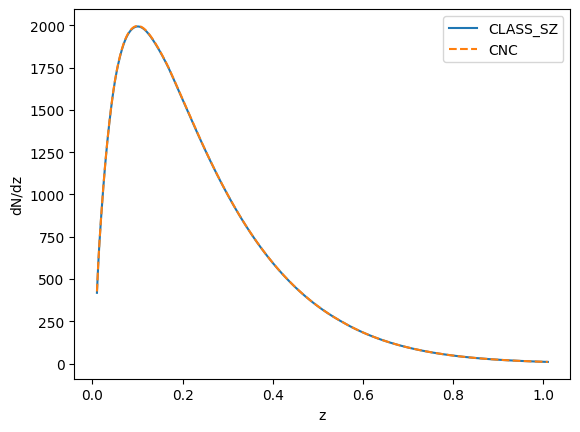

In [57]:
plt.plot(z_arr,Nz,label='CLASS_SZ')
# z_inigo,dnz_inigo = np.loadtxt('/Users/boris/Downloads/n_z.txt',unpack=True)
z_inigo,dnz_inigo = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/cnc/test_files/n_z.txt',unpack=True)

# plt.plot(z_inigo,dnz_inigo,label='inigo',ls='--')
interdnz = np.exp(np.interp(np.log(1.+z_arr),np.log(1.+z_inigo),np.log(dnz_inigo)))
plt.plot(z_arr,interdnz,label='CNC',ls='--')
# plt.plot(z_arr,Nz)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.legend()
# plt.yscale('log')
plt.savefig('dndz.pdf')


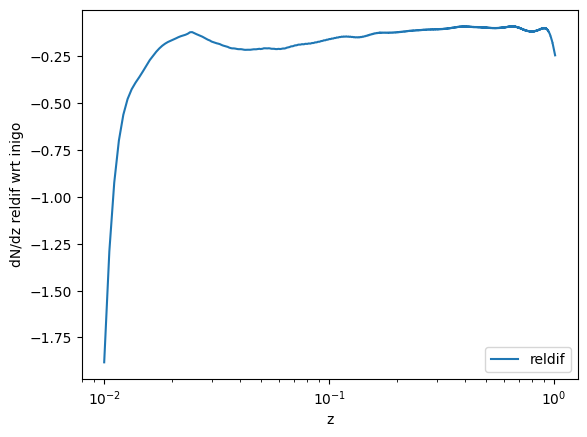

In [17]:
plt.plot(z_arr,100*(Nz/interdnz-1.),label='reldif')
plt.xlabel('z')
plt.ylabel('dN/dz reldif wrt inigo')
# plt.yscale('log')
plt.xscale('log')
plt.legend()

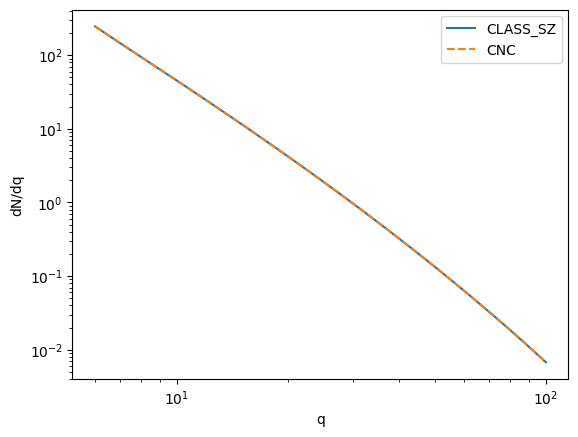

In [56]:
plt.plot(q_arr,Nq,label='CLASS_SZ')
# plt.plot(dndq_inigo[0],dndq_inigo[1],ls='--')
# z_inigo,dnz_inigo = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/cnc/test_files/n_z.txt',unpack=True)
q_inigo,dnq_inigo = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/cnc/test_files/n_q.txt',unpack=True)
# plt.plot(q_inigo,dnq_inigo,label='inigo',ls='--')
interdn = np.exp(np.interp(np.log(q_arr),np.log(q_inigo),np.log(dnq_inigo)))
plt.plot(q_arr,interdn,label='CNC',ls='--')
plt.xlabel('q')
plt.ylabel('dN/dq')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('dndq.pdf')

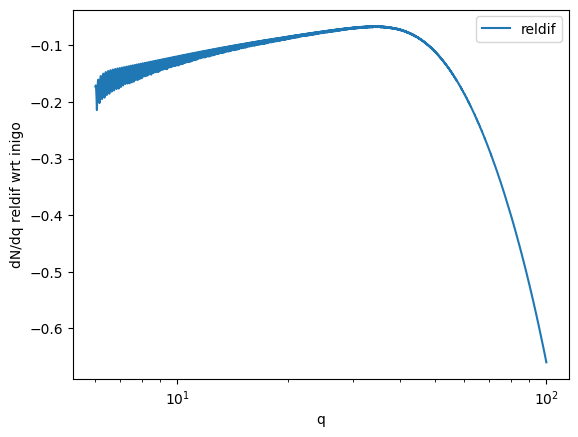

In [19]:
# plt.plot(q_arr,Nq,label='boris')
# plt.plot(dndq_inigo[0],dndq_inigo[1],ls='--')
# interdn = np.exp(np.interp(np.log(q_arr),np.log(q_inigo),np.log(dndq_inigo)))
plt.plot(q_arr,100*(Nq/interdn-1.),label='reldif')
plt.xlabel('q')
plt.ylabel('dN/dq reldif wrt inigo')
# plt.yscale('log')
plt.xscale('log')
plt.legend()

# Binned computation (a la planck)

In [20]:
%%time

M_binned = Class()

M_binned.set(common_params)
M_binned.set(cosmo_params_comparison)
M_binned.set({
    
'output' : 'sz_cluster_counts',
'mass function' :  'M500',
'has_selection_function' : 1,
'experiment' : 0,
'y_m_relation' : 0,
'use_skyaveraged_noise': 1,
'use_planck_binned_proba' : 0,


'm_pivot_ym_[Msun]': 3e14,    

'M_min' : 1e13*h, 
'M_max' : 1e16*h,

'z_min' : 0.,
'z_max' : 1.02,





'bin_z_min_cluster_counts' : 0.01,
'bin_z_max_cluster_counts' : 1.01,
'bin_dz_cluster_counts' : 0.1,
'bin_dlog10_snr': 0.25,

#the paramater dlny is crucial, it controls the speed of the calculation
#important to check that lnymin and lnymax are broad enough
'dlny' : 0.05,
'lnymin' : -11.,
'lnymax' : 1.,
'sigmaM_ym' : 0.173,

#case with no scatter:
#sigmaM_ym = 0.

'dlnM_cluster_count_completeness_grid' : 0.01,


'cluster_count_completeness_grid_z_cutoff_low' : 0.5,
'cluster_count_completeness_grid_z_cutoff_mid' : 1.5,
'dz_cluster_count_completeness_grid_low_z' : 5e-3,
'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
'dz_cluster_count_completeness_grid_high_z' : 1e-1,





'signal-to-noise_cut-off_for_survey_cluster_completeness' : 6,


# X ray mass bias (if applicable)
'B' : 1.25,




# tabulation of mass function:
'n_z_dndlnM' : 500,
'n_m_dndlnM' : 1000,

# computation of mass function
# (grid in mass and redshifts for sigma and dsigma)
# 'ndim_masses' : 500,
'ndim_redshifts' : 500,

# # pk setup for computation of sigma and dsigma
# 'k_per_decade_class_sz' : 20.,
# 'k_min_for_pk_class_sz' : 1e-3,
# 'k_max_for_pk_class_sz' : 1e1,
# 'P_k_max_h/Mpc' : 1e1,
})
M_binned.compute_class_szfast()

CPU times: user 3.93 s, sys: 675 ms, total: 4.61 s
Wall time: 1.94 s


In [21]:
dNdzdy_theoretical = M_binned.dndzdy_theoretical()['dndzdy']
z_center = M_binned.dndzdy_theoretical()['z_center']
z_edges = M_binned.dndzdy_theoretical()['z_edges']
log10y_center = M_binned.dndzdy_theoretical()['log10y_center']
log10y_edges = M_binned.dndzdy_theoretical()['log10y_edges']

N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_with_rel = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
N_clusters_y_theory_with_rel = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))


In [22]:
np.sum(N_clusters_z_theory)

625.7569013547846

# Get the binned from unbinned and compare

In [23]:

z_edges_low = z_edges[:-1]
z_edges_high = z_edges[1:]
Nz_binned = []
for (zm,zp) in zip(z_edges_low,z_edges_high):
    z_arr_bin = np.linspace(zm,zp,50)
    Nz_in = []
    for zpbin in z_arr_bin:
        Nz_in.append(np.trapz(get_dndzdq(zpbin,q_arr)*q_arr,x=np.log(q_arr)))
    Nz_binned.append(np.trapz(Nz_in,x=z_arr_bin))
Nz_binned = np.asarray(Nz_binned)

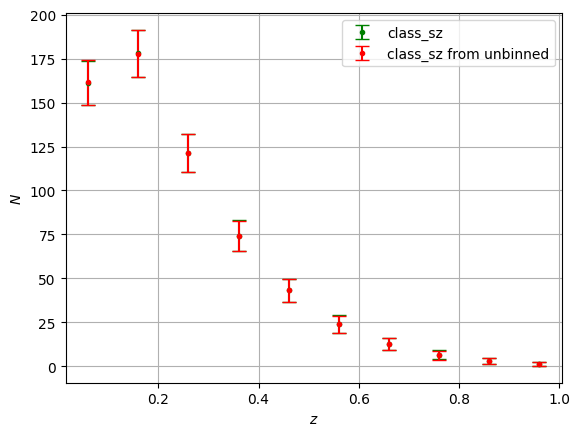

In [55]:
plt.errorbar(z_center,N_clusters_z_theory,yerr=np.sqrt(N_clusters_z_theory),marker='o',markersize=3.,ls='none',label='class_sz',capsize=5,c='green')
plt.errorbar(z_center,Nz_binned,yerr=np.sqrt(Nz_binned),marker='o',markersize=3.,ls='none',label='class_sz from unbinned',capsize=5,c='red')

plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.savefig('N_of_z.pdf')

# Heat map of dndzdq

In [44]:
z_array_2d = np.linspace(0.01,0.5,500)
log10q_array = np.linspace(np.log10(6.),np.log10(15.),500)
dndzdq_2d = np.zeros((500,500))
izp = 0
ilq = 0
for zp in z_array_2d:
    ilq=0
    for lq in log10q_array:
        dndzdq_2d[izp][ilq] = get_dndzdq(zp,10**lq)
        ilq+=1
    izp+=1

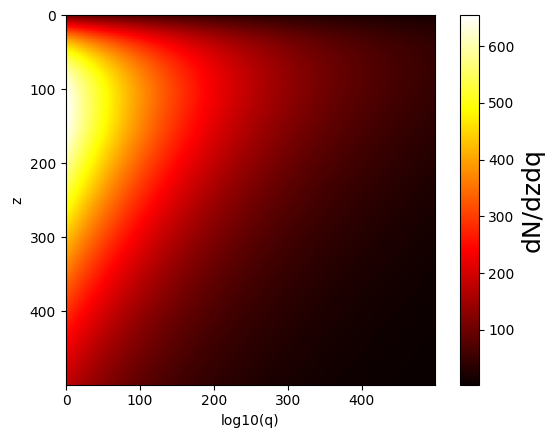

In [58]:
im = plt.imshow(dndzdq_2d, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) # adding the colobar on the right
cbar.set_label('dN/dzdq',size=18)
plt.xlabel('log10(q)')
plt.ylabel('z')
# plt.show()
plt.savefig('clustercounts_heatmap.pdf')